# Examples of how we can verify MPAS forecasts against global GFS analyses

## Load the forecast and analyses

In [1]:
from mpasoutput import MPASprocessed
from datetime import datetime
workdir = '/glade/scratch/njweber2/experiments/24km_4day_20170401'
idate = datetime(2017, 4, 1, 0)
fdate = datetime(2017, 4, 5, 0)
dt = 3

# Load the GFS analyses and store them in the same object we use to 
# store MPAS forecasts. This is nice because then we can use the same 
# functions, attributes, and plotting tools for both the forecasts and verification.
#
# The from_GFS_netcdf function will automatically download GFS gribs from  
# NOMADS, convert them to netcdf format, and create an MPASprocessed 
# object from that netcdf
gfs_anl = MPASprocessed.from_GFS_netcdf(workdir, idate, fdate, chunks={"time":10})
lats, lons = gfs_anl.latlons()

In [2]:
# Now let's interpolate our MPAS forecasts onto the same lat/lon grid as GFS
mpas_fcst = MPASprocessed.from_latlon_grid(lats, lons, workdir, idate, 1, 
                                outputfile='diags_gfs_latlon.nc', chunks={"Time":10})
mpas_fcst = mpas_fcst.temporally_coarsen(dt) # coarsens the forecast to 3-hourly

Interpolating diag.*.nc to regularly-spaced lat-lon grid...
cd /glade/scratch/njweber2/experiments/24km_4day_20170401; ./convert_mpas *init.nc diag.*.nc
Elapsed time: 1.13 min


## Verification at a single point

Fetching data at 43.00N 270.50E
Fetching data at 43.00N 270.50E
Fetching data at 43.00N 270.50E
Fetching data at 43.00N 270.50E
Fetching data at 43.00N 270.50E
Fetching data at 43.00N 270.50E


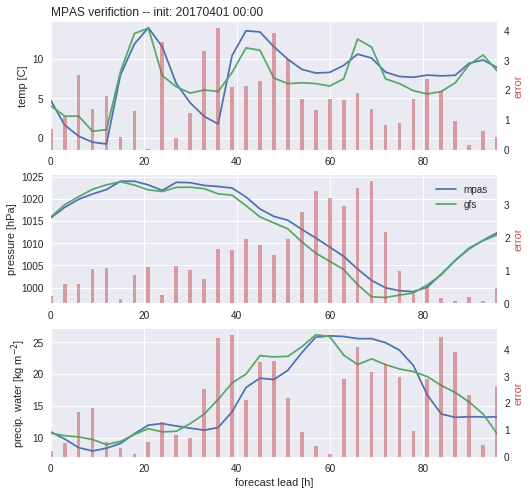

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns     # fancy plots
colors = sns.color_palette()
%matplotlib inline

# Get the timeseries
pt = (43.0731, -89.4012)  # Madison, WI
x = gfs_anl.leadtimes()  # should be the same as the MPAS lead times
gt2m   = gfs_anl.get_timeseries('t2m', pt) - 273.15
gmslp  = gfs_anl.get_timeseries('mslp', pt) / 100.
gpwat  = gfs_anl.get_timeseries('precipw', pt)
mt2m   = mpas_fcst.get_timeseries('t2m', pt) - 273.15
mmslp  = mpas_fcst.get_timeseries('mslp', pt) / 100.
mpwat  = mpas_fcst.get_timeseries('precipw', pt)
ylabs = ['temp [C]', 'pressure [hPa]', 'precip. water [kg m$^{-2}$]']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
for ax, data, ylab in zip(axes, [(mt2m, gt2m), (mmslp, gmslp), \
                                 (mpwat, gpwat)], ylabs):
    ax2 = ax.twinx()
    ln3 = ax2.bar(x, np.abs(data[0]-data[1]), label='error', 
                  color=colors[2], alpha=0.5)
    ln1 = ax.plot(x, data[0], label='mpas', color=colors[0])
    ln2 = ax.plot(x, data[1], label='gfs', color=colors[1])
    ax.set_ylabel(ylab)
    ax2.set_ylabel('error', color=colors[2])
    ax2.grid('off')
    if ax==axes[1]: ax.legend(loc='best')
    ax.set_xlim((x[0], x[-1]))
axes[0].set_title('MPAS verifiction -- init: {:%Y%m%d %H:00}'.format(idate),
                  loc='left')
axes[2].set_xlabel('forecast lead [h]')

plt.show()

## Mean absolute error timeseries

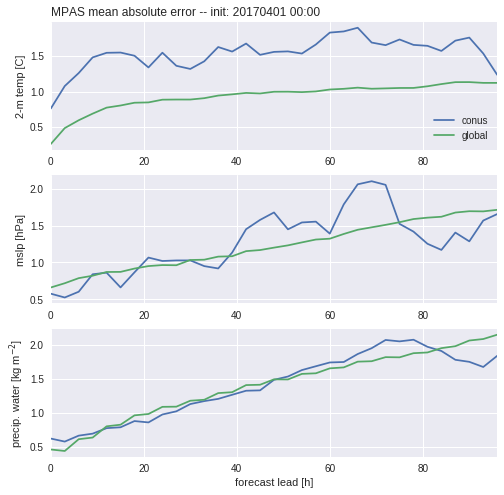

In [4]:
from verification import compute_spatial_error
errt2m_glob = compute_spatial_error('t2m', mpas_fcst, gfs_anl)
errt2m = compute_spatial_error('t2m', mpas_fcst, gfs_anl, lllat=35, 
                               lllon=233, urlat=50, urlon=295)
errp_glob = compute_spatial_error('mslp', mpas_fcst, gfs_anl) / 100.
errp = compute_spatial_error('mslp', mpas_fcst, gfs_anl, lllat=35, 
                             lllon=233, urlat=50, urlon=295) / 100.
errw_glob = compute_spatial_error('precipw', mpas_fcst, gfs_anl)
errw = compute_spatial_error('precipw', mpas_fcst, gfs_anl, lllat=35, 
                             lllon=233, urlat=50, urlon=295)

ylabs = ['2-m temp [C]', 'mslp [hPa]', 'precip. water [kg m$^{-2}$]']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
for ax, data, ylab in zip(axes, [(errt2m, errt2m_glob), (errp, errp_glob), \
                                 (errw, errw_glob)], ylabs):
    ln1 = ax.plot(x, data[0], label='conus', color=colors[0])
    ln2 = ax.plot(x, data[1], label='global', color=colors[1])
    ax.set_ylabel(ylab)
    if ax==axes[0]: ax.legend(loc='best')
    ax.set_xlim((x[0], x[-1]))
axes[0].set_title('MPAS mean absolute error -- init: {:%Y%m%d %H:00}'.format(idate),
                  loc='left')
axes[2].set_xlabel('forecast lead [h]')
plt.show()

## We can do the same with other error statistics, like bias

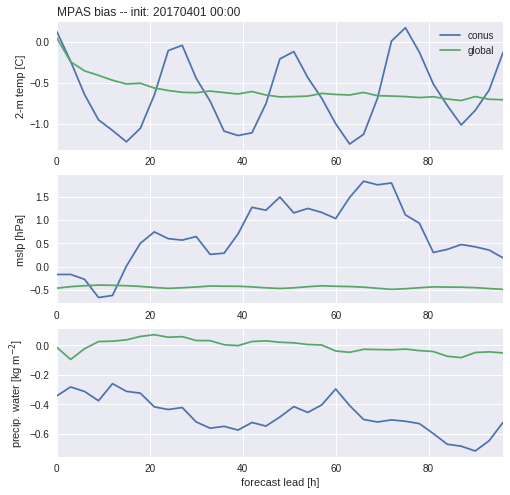

In [5]:
errt2m_glob = compute_spatial_error('t2m', mpas_fcst, gfs_anl, err='bias')
errt2m = compute_spatial_error('t2m', mpas_fcst, gfs_anl, lllat=35, 
                               lllon=233, urlat=50, urlon=295, err='bias')
errp_glob = compute_spatial_error('mslp', mpas_fcst, gfs_anl, err='bias') / 100.
errp = compute_spatial_error('mslp', mpas_fcst, gfs_anl, lllat=35, 
                             lllon=233, urlat=50, urlon=295, err='bias') / 100.
errw_glob = compute_spatial_error('precipw', mpas_fcst, gfs_anl, err='bias')
errw = compute_spatial_error('precipw', mpas_fcst, gfs_anl, lllat=35, 
                             lllon=233, urlat=50, urlon=295, err='bias')

ylabs = ['2-m temp [C]', 'mslp [hPa]', 'precip. water [kg m$^{-2}$]']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
for ax, data, ylab in zip(axes, [(errt2m, errt2m_glob), (errp, errp_glob), \
                                 (errw, errw_glob)], ylabs):
    ln1 = ax.plot(x, data[0], label='conus', color=colors[0])
    ln2 = ax.plot(x, data[1], label='global', color=colors[1])
    ax.set_ylabel(ylab)
    if ax==axes[0]: ax.legend(loc='best')
    ax.set_xlim((x[0], x[-1]))
axes[0].set_title('MPAS bias -- init: {:%Y%m%d %H:00}'.format(idate),
                  loc='left')
axes[2].set_xlabel('forecast lead [h]')
plt.show()

## Error map at a single time

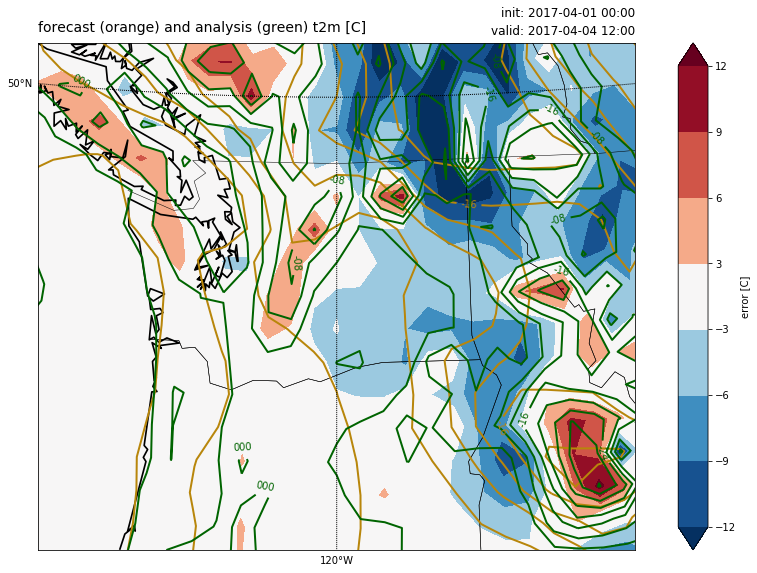

In [6]:
sns.reset_orig() # restore normal matplotlib rc parameters
from plotting_mpas_latlon import draw_fig_axes
from verification import errormap
import warnings
warnings.filterwarnings('ignore')
fig, ax, cax, m = draw_fig_axes(proj='stereWA')
mpas_fcst['t2m'] -= 273.15
gfs_anl['t2m'] -= 273.15
vdate = datetime(2017, 4, 4, 12)
errormap(m, ax, cax, 't2m', mpas_fcst, gfs_anl, np.arange(-40, 50, 4),
             idate=idate, vdate=vdate, units='C')
plt.show()

## Forecast bias over the whole simulation

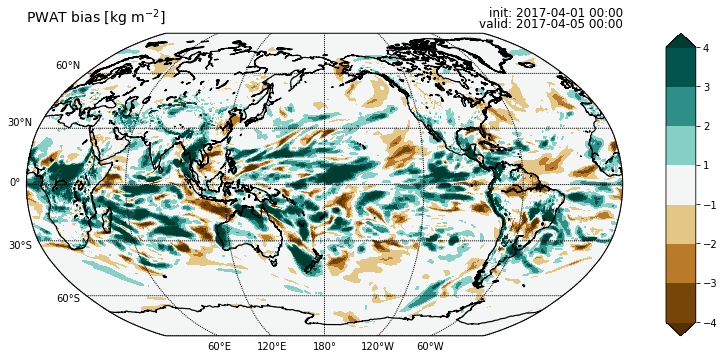

In [7]:
from verification import compute_temporal_error
from plotting_mpas_latlon import simple_contourf
from color_maker.color_maker import color_map

pwat_bias = compute_temporal_error('precipw', mpas_fcst, gfs_anl, err='bias')
vdate = datetime(2017, 4, 5, 0)
fig, ax, cax, m = draw_fig_axes(proj='robinGlobal')
x, y = mpas_fcst.project_coordinates(m)
simple_contourf(m, ax, cax, x, y, pwat_bias, cmap=color_map('CBR_drywet'), 
                varname='PWAT bias', idate=idate, vdate=vdate, 
                units='kg m$^{-2}$', div=True)
plt.show()